Team: ml_explorers

Team Members:
1. Rishabh Bansal(rishabhb@usc.edu)
2. Chiransh Gulati(cgulati@usc.edu)
3. Ankur Kumar Goyal(akgoyal@usc.edu)

# Importing all packages

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import collections
import numpy as np
import pandas as pd
import math
import os

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 100)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.inspection import permutation_importance
from IPython.display import display, HTML, display_html
display(HTML("<style>.container { width:100% !important; }</style>"))

from mlxtend.regressor import StackingCVRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold


from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns

# for variable transformation
import scipy.stats as stats
from scipy.stats import norm, skew

import gc
gc.enable()
random_state = 55

%matplotlib inline
sns.set_style("whitegrid")
sns.set(font_scale= 1)
pd.pandas.set_option('display.max_columns', None)

Loading Train and Test data sets.

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

A general overview of the data we need to work with. 
A few lines of code going from high level overview to lower/more detailed levels.

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


**Checking to see data types and potential missing values**:

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Numerical/Categorical Features

In [5]:
# Identifying categorical variables
categorical = [var for var in train.columns if train[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

# Identifying numerical variables
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 43 categorical variables
There are 38 numerical variables


**Descriptive statistics:**

In [6]:
display(
    train.describe().iloc[:, 0:18].applymap("{:,g}".format),
    train.describe().iloc[:, 18:].applymap("{:,g}".format),
)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath
count,"1,460","1,460","1,201","1,460","1,460","1,460","1,460","1,460","1,452","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460"
mean,730.5,56.8973,70.05,"10,516.8",6.09932,5.57534,"1,971.27","1,984.87",103.685,443.64,46.5493,567.24,"1,057.43","1,162.63",346.992,5.84452,"1,515.46",0.425342
std,421.61,42.3006,24.2848,"9,981.26",1.383,1.1128,30.2029,20.6454,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.6231,525.48,0.518911
min,1,20,21,"1,300",1,1,"1,872","1,950",0,0,0,0,0,334,0,0,334,0
25%,365.75,20,59,"7,553.5",5,5,"1,954","1,967",0,0,0,223,795.75,882,0,0,"1,129.5",0
50%,730.5,50,69,"9,478.5",6,5,"1,973","1,994",0,383.5,0,477.5,991.5,"1,087",0,0,"1,464",0
75%,"1,095.25",70,80,"11,601.5",7,6,"2,000","2,004",166,712.25,0,808,"1,298.25","1,391.25",728,0,"1,776.75",1
max,"1,460",190,313,"215,245",10,9,"2,010","2,010","1,600","5,644","1,474","2,336","6,110","4,692","2,065",572,"5,642",3


,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,379","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460"
mean,0.0575342,1.56507,0.382877,2.86644,1.04658,6.51781,0.613014,"1,978.51",1.76712,472.98,94.2445,46.6603,21.9541,3.40959,15.061,2.7589,43.489,6.32192,"2,007.82","180,921"
std,0.238753,0.550916,0.502885,0.815778,0.220338,1.62539,0.644666,24.6897,0.747315,213.805,125.339,66.256,61.1191,29.3173,55.7574,40.1773,496.123,2.70363,1.3281,"79,442.5"
min,0,0,0,0,0,2,0,"1,900",0,0,0,0,0,0,0,0,0,1,"2,006","34,900"
25%,0,1,0,2,1,5,0,"1,961",1,334.5,0,0,0,0,0,0,0,5,"2,007","129,975"
50%,0,2,0,3,1,6,1,"1,980",2,480,0,25,0,0,0,0,0,6,"2,008","163,000"
75%,0,2,1,3,1,7,1,"2,002",2,576,168,68,0,0,0,0,0,8,"2,009","214,000"
max,2,3,2,8,3,14,3,"2,010",4,"1,418",857,547,552,508,480,738,"15,500",12,"2,010","755,000"


In [7]:
Id = "Id"
submission_ID = test.loc[:, Id]
train.drop(Id, axis=1, inplace=True)
test.drop(Id, axis=1, inplace=True)

# Creating Train flag to segregate train and test sets before concatinating
train.loc[:, "Train"] = 1
test.loc[:, "Train"] = 0
test["SalePrice"] = 0
combined_DF = pd.concat([train, test], ignore_index=True)

# Data Coorelation Analysis

<AxesSubplot:>

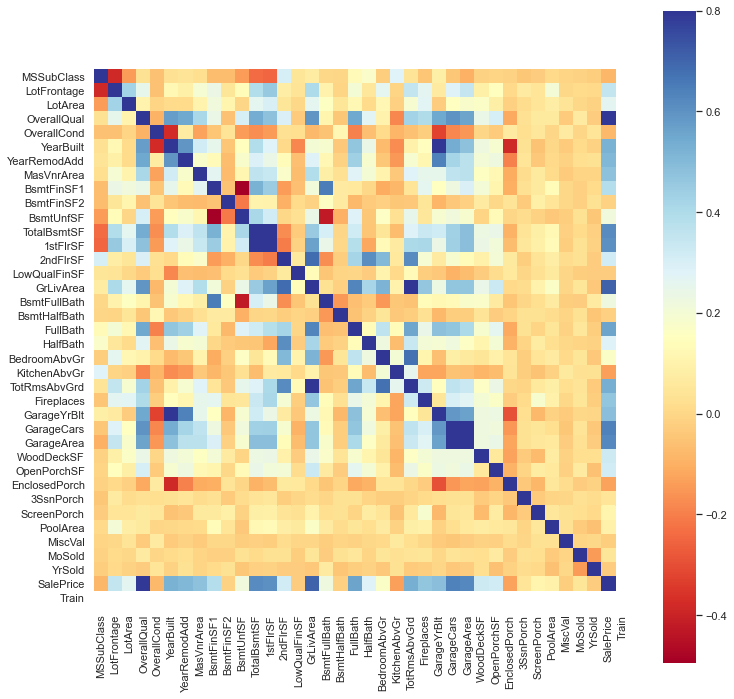

In [8]:
corr_matrix =  train.corr()
sns.set(rc = {'axes.facecolor':'white', 'figure.facecolor':'white'})
f, ax  = plt.subplots(figsize= (12, 12))
sns.heatmap(corr_matrix, vmax = .8, square=True, cmap="RdYlBu")

####  Top 10 positively corelated features with 'SalePrice'

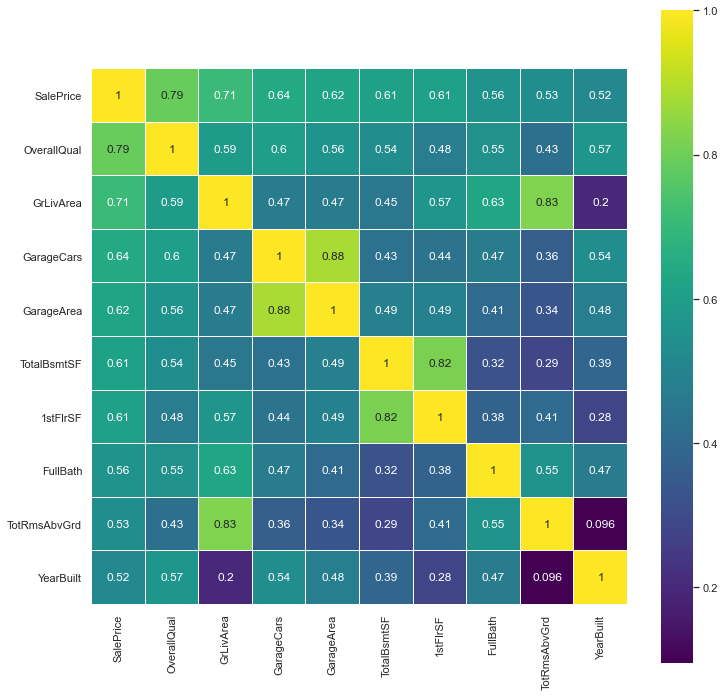

In [9]:
k = 10
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
f , ax = plt.subplots(figsize = (12,12))
hmm = sns.heatmap(cm,linewidths=0.01, annot=True, cmap = 'viridis', annot_kws={'size': 12}, square=True, xticklabels=cols.values, yticklabels = cols.values)
plt.show()

#### Observations
1. 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
2. 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However we know that the number of cars that fit into the garage is a consequence of the garage area.Therefore, we just need one of these variables in our analysis. We can keep 'GarageCars' since its correlation with 'SalePrice' is higher.

####  Top 10 negatively correlated features with 'SalePrice'

Index(['SalePrice', 'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold',
       'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch'],
      dtype='object')


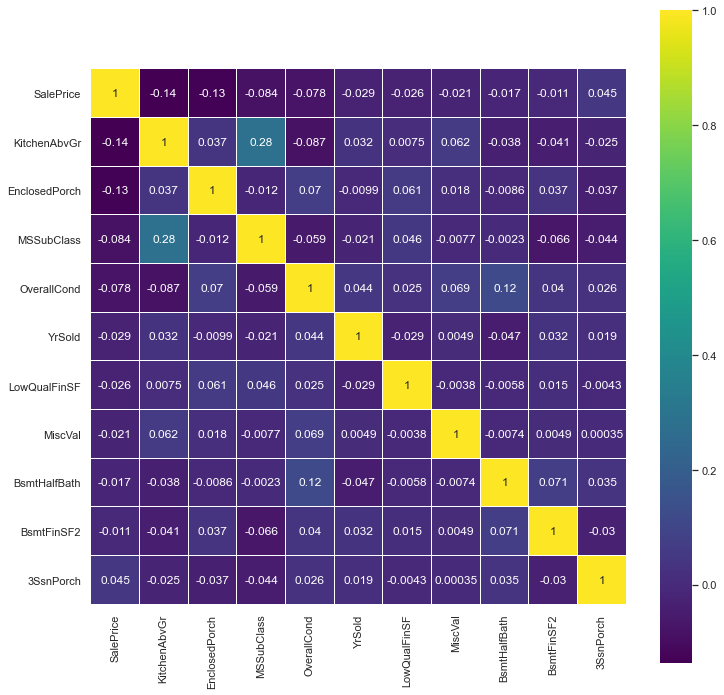

In [10]:
k = 10
cols = corr_matrix.nlargest(1,'SalePrice')['SalePrice'].append(corr_matrix.nsmallest(k,'SalePrice')['SalePrice'])
cols_index = cols.index
print(cols_index)
cm = np.corrcoef(train[cols_index].values.T)
f , ax = plt.subplots(figsize = (12,12))
hmm = sns.heatmap(cm,linewidths=0.01, annot=True, cmap = 'viridis', annot_kws={'size': 12}, square=True,xticklabels=cols_index.values, yticklabels = cols_index.values)
plt.show()

In [11]:
attrs = corr_matrix.iloc[:-1,:-1] # all except target
threshold = 0.5

important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]).unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), important_corrs[key]) for key in important_corrs])), columns=['Feature_Pair', 'Corr'])

# sorted by absolute value
imp_corr = unique_important_corrs.iloc[abs(unique_important_corrs['Corr']).argsort()[::-1]]
imp_corr


,Feature_Pair,Corr
14,"(GarageArea, GarageCars)",0.88
34,"(GarageYrBlt, YearBuilt)",0.83
5,"(GrLivArea, TotRmsAbvGrd)",0.83
33,"(1stFlrSF, TotalBsmtSF)",0.82
25,"(OverallQual, SalePrice)",0.79
32,"(GrLivArea, SalePrice)",0.71
17,"(2ndFlrSF, GrLivArea)",0.69
9,"(BedroomAbvGr, TotRmsAbvGrd)",0.68
3,"(BsmtFinSF1, BsmtFullBath)",0.65
18,"(GarageYrBlt, YearRemodAdd)",0.64


#### Here we are trying to show the multicollinearity. In regression, multicollinearity refers to features that are coorelated with other features. Multicollonearity occurs when your model includes multiple factors that are coorrelated to each other as well and not just to your target variable.

Problem:
Multicollinearity increases the standard errors of the cooefficients. That means, multicollinearity makes some variables statistically insignificant when they should be significant.

To Avoid:
1. Completely remove those variables
2. Make new features by adding them or by some other operation.
3. Use PCA, which will reduce feature set to small number of non-collinear feature

In [12]:
#coorelation with our target Variable - SalePrice
corr_matrix['SalePrice']

MSSubClass      -0.08
LotFrontage      0.35
LotArea          0.26
OverallQual      0.79
OverallCond     -0.08
YearBuilt        0.52
YearRemodAdd     0.51
MasVnrArea       0.48
BsmtFinSF1       0.39
BsmtFinSF2      -0.01
BsmtUnfSF        0.21
TotalBsmtSF      0.61
1stFlrSF         0.61
2ndFlrSF         0.32
LowQualFinSF    -0.03
GrLivArea        0.71
BsmtFullBath     0.23
BsmtHalfBath    -0.02
FullBath         0.56
HalfBath         0.28
BedroomAbvGr     0.17
KitchenAbvGr    -0.14
TotRmsAbvGrd     0.53
Fireplaces       0.47
GarageYrBlt      0.49
GarageCars       0.64
GarageArea       0.62
WoodDeckSF       0.32
OpenPorchSF      0.32
EnclosedPorch   -0.13
3SsnPorch        0.04
ScreenPorch      0.11
PoolArea         0.09
MiscVal         -0.02
MoSold           0.05
YrSold          -0.03
SalePrice        1.00
Train             nan
Name: SalePrice, dtype: float64

#####  As we saw there are few feature which shows high multicollinearity from heatmap.

Our Main focus will be:

1. SalePrice and OverallQual
2. GarageArea and GarageCars
3. TotalBsmtSF and 1stFlrSF
4. GrLiveArea and TotRmsAbvGrd
5. YearBulit and GarageYrBlt


We have to create a single feature or remove one of them before we use them as predictors.


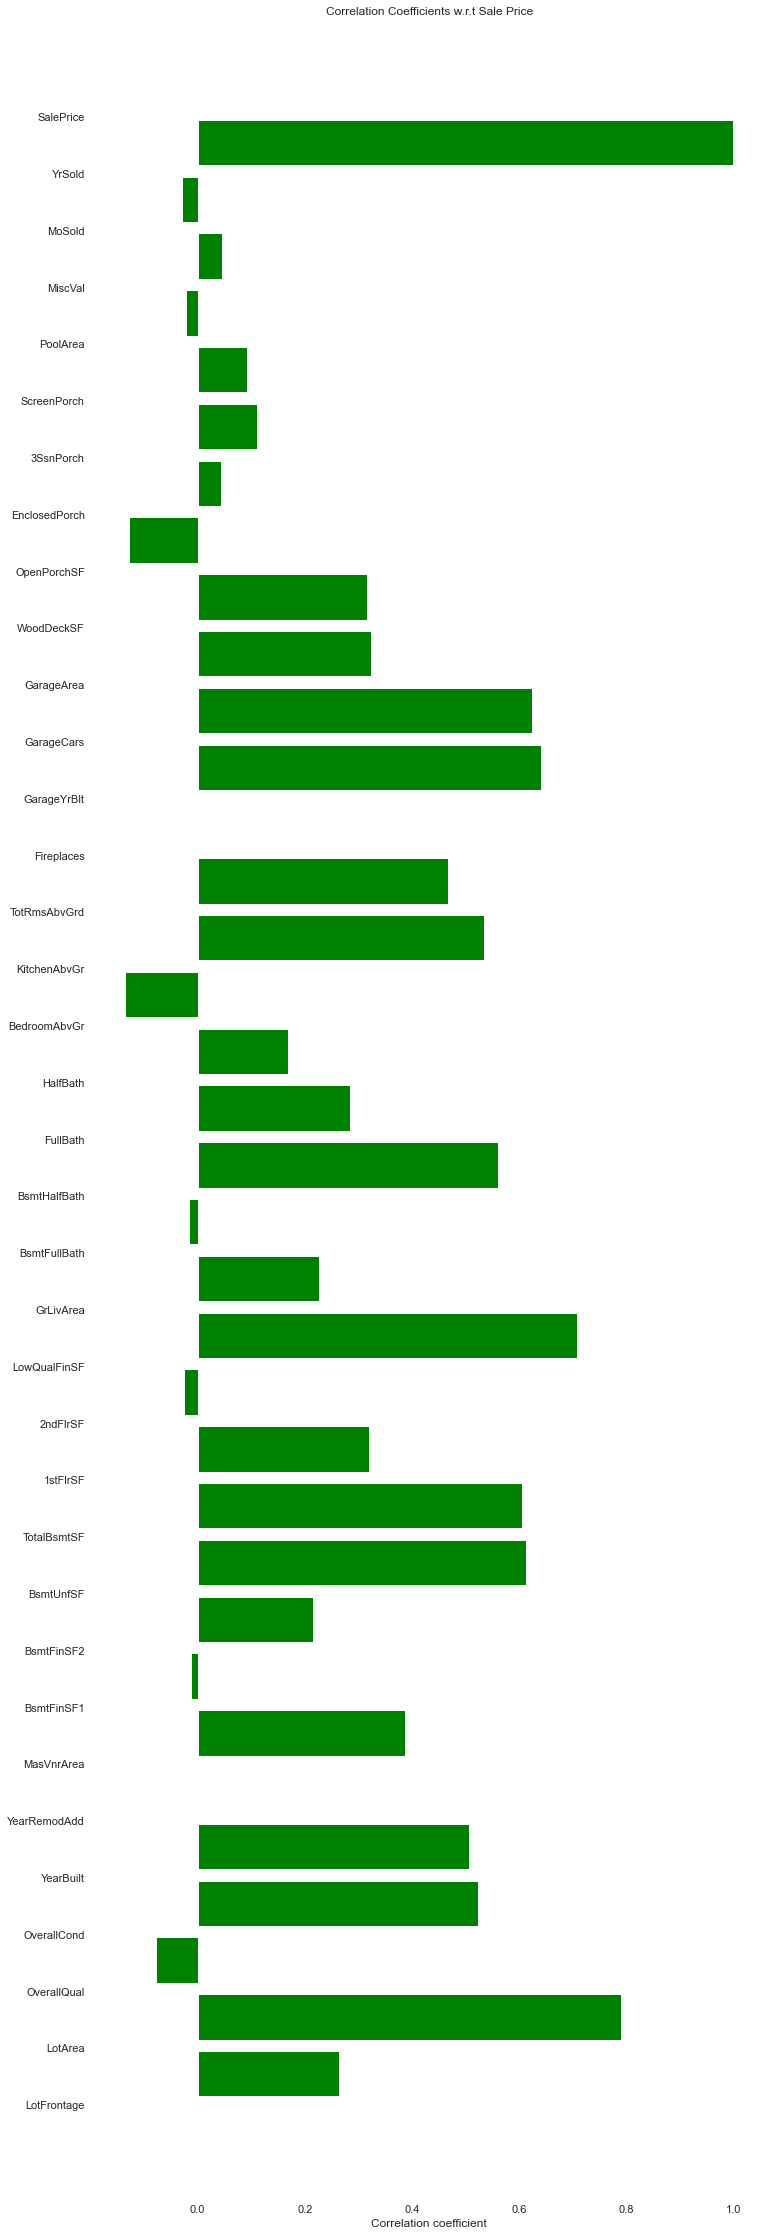

In [13]:
num_feat = train.columns[train.dtypes != object]
num_feat = num_feat[1:-1]
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.SalePrice.values)[0,1])
    
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(values), color='green')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sale Price");

#### Observations from Correlation plot
- OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbcGrd, YearBuilt, YearRemodAdd have positive correlation with SalePrice (> 0.5)
- EnclosedPorch and KitchenAbvGr have negative correlation with target Variable
- These features can prove to be important features to predict SalePrice.

####  Interesting Plot

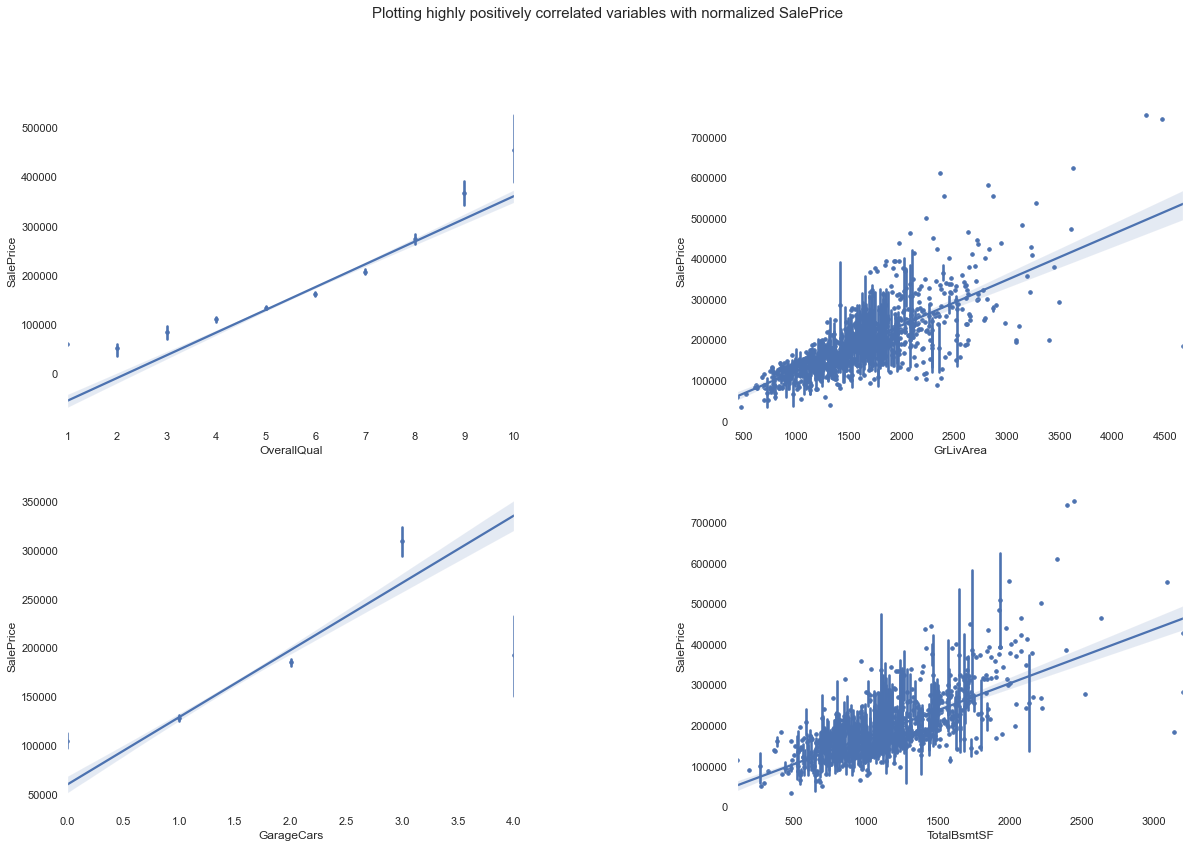

In [14]:
train_scatter = train.copy()
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']<3500.0]
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']>0.0]

def plot_scatter(features,title):
    fig, (axs,axs1) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
    fig.subplots_adjust(wspace=0.5)
    for i in range(0,len(features)):
        plot = pd.concat([train_scatter['SalePrice'],train_scatter[features[i]]],axis = 1)
        if i<2 :
            g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs[i])
        else:
            g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs1[i-2])
        fig.suptitle("Plotting highly "+title+"ly correlated variables with normalized SalePrice",fontsize="15")
        if title=='negative':
            g.set(xticklabels=feat_labels[features[i]])
  
pos_features =['OverallQual','GrLivArea','GarageCars','TotalBsmtSF']
plot_scatter(pos_features,'positive')

del train_scatter

# Target Variable Distribution - Univariate Analysis

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

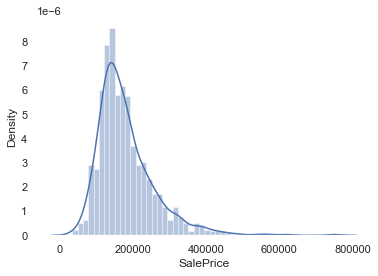

In [15]:
# The density plot of SalePrice
sns.distplot(train['SalePrice'], bins = 50)

#### From Here we can see that Sales Price is
* Deviate from normal distribution
* Is right-skewed  
* shows some peakedness

# Target Variable Distribution - Continuous Bivariate Analyis

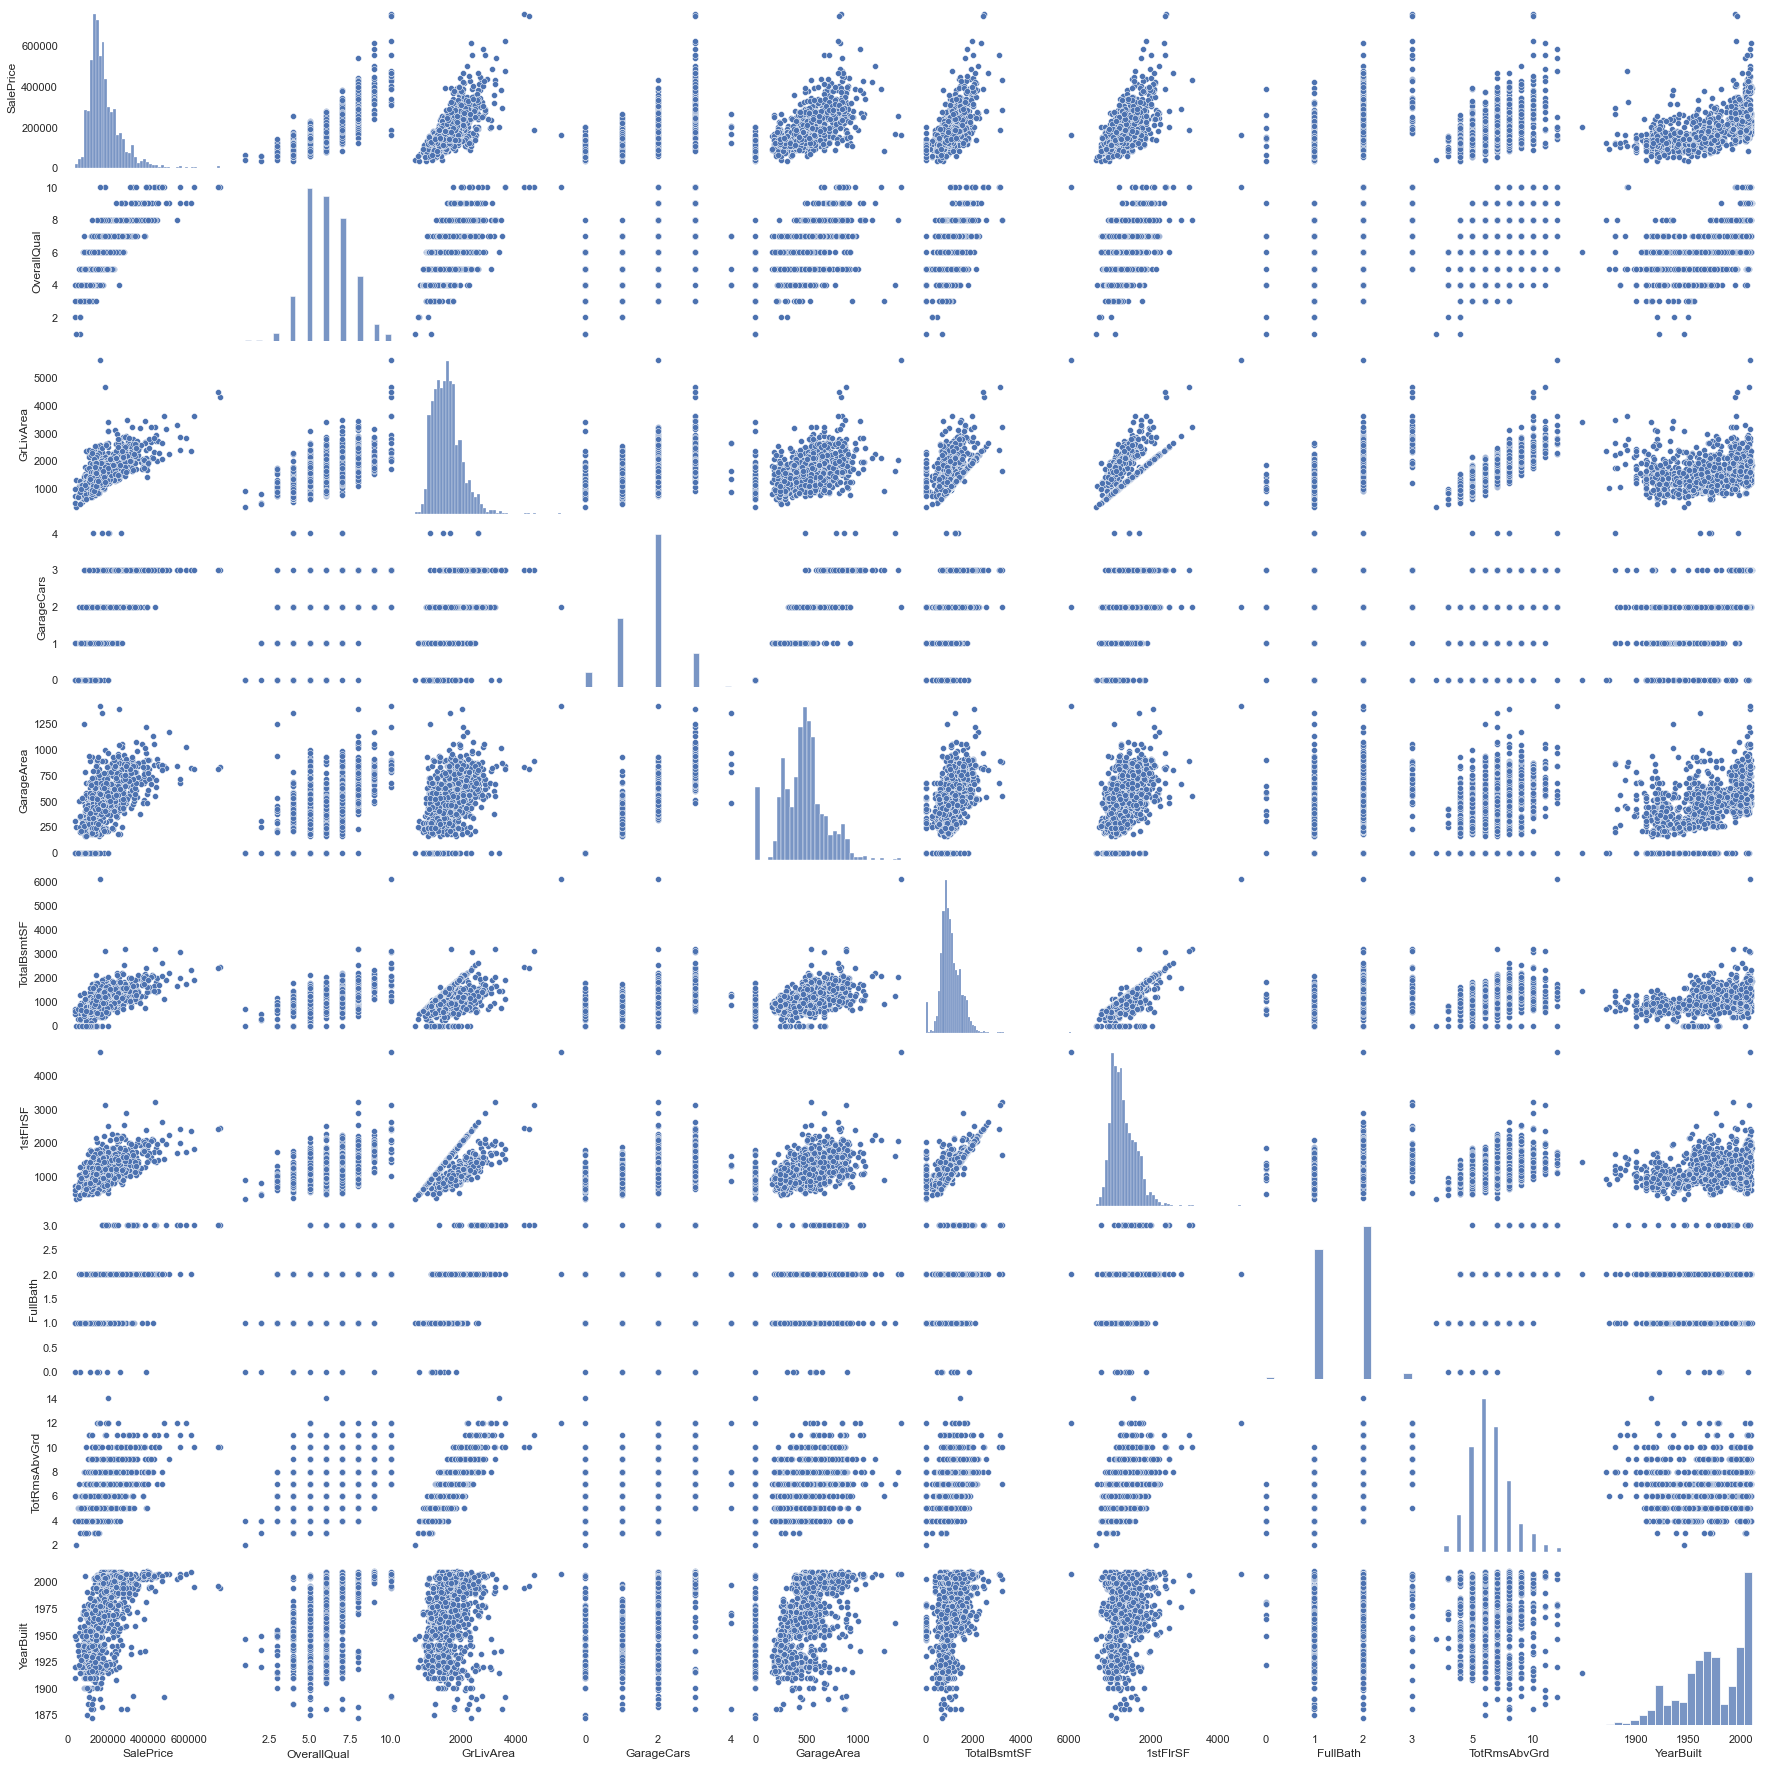

In [16]:
corr_matrix =  train.corr()
cols = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
sns.pairplot(train[cols], height=2.5)
plt.show()

####  Observations 
1. One of the intersting figure is 'TotalBsmtSF' and 'GrLiveArea'. We can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area
2. The plot  'SalePrice' and 'YearBuilt' is also intersting. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function. We can also see this same tendency in the upper limit of the 'dots cloud'. Also, we noticed how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).


# Target Variable Distribution - Catagorical Bivariate Analyis

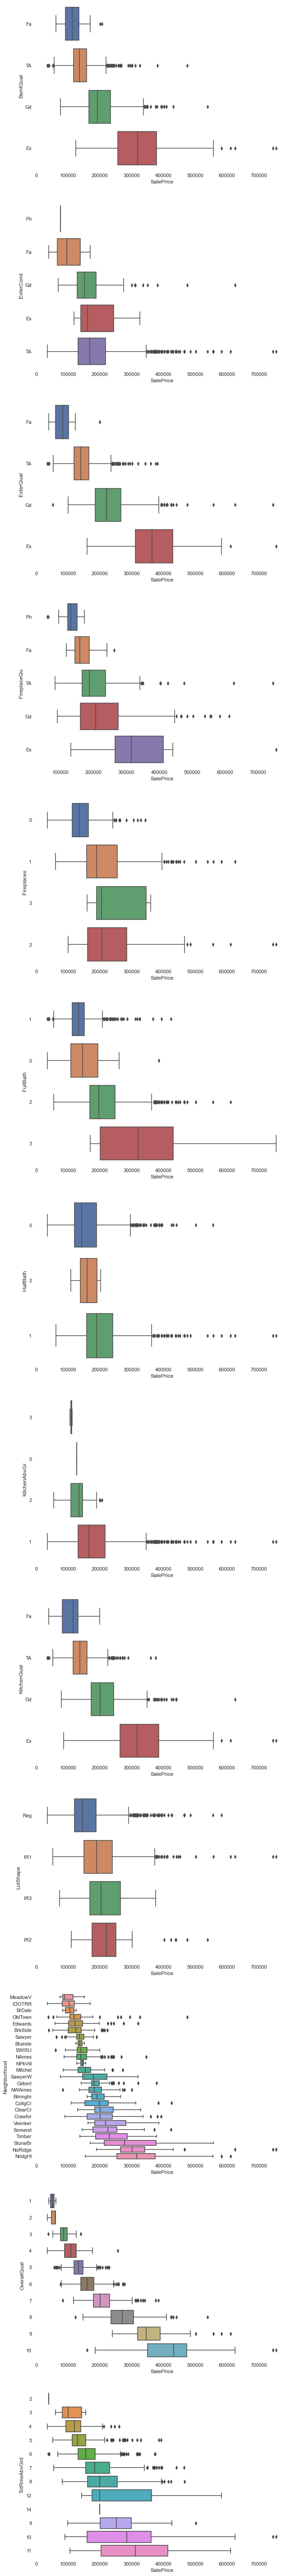

In [17]:
features_to_viz = ["Neighborhood", "BsmtQual", "ExterQual", "FireplaceQu", "ExterCond", "KitchenQual", "LotShape", "OverallQual", "FullBath", "HalfBath", "TotRmsAbvGrd", "Fireplaces", "KitchenAbvGr"]
features_to_viz = sorted(features_to_viz)

ncols = 1
nrows = math.ceil(len(features_to_viz) / ncols)
unused = nrows * ncols - len(features_to_viz)

(figw, figh) = (ncols * 10, nrows * 8)

(fig, ax) = plt.subplots(nrows, ncols, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for n,col in enumerate(features_to_viz):
    ordering = combined_DF.loc[combined_DF["Train"] == 1].groupby(by=col)["SalePrice"].median().sort_values().index
    sns.boxplot(x="SalePrice", y=col, data=combined_DF.loc[combined_DF["Train"] == 1], order=ordering, ax=ax[n], orient="h")
plt.show()

#### Observations

 - MasVnrType has strong correlation with 'YearBuilt' and 'OverallQual'which are already considered, so we can remove this variable
 - OverallQual impacts SalePrice exponentially
 - Features representing quality aspect of property like Neighbourhood matter a lot.
 - The more irregular the lot shape is, the higher the Sale Price seems to be

# Missing Values Analysis

In [18]:
print("Missing Value Counts in Training Data")
combined_DF[combined_DF["Train"] == 1].isna().sum()[combined_DF[combined_DF["Train"] == 1].isna().sum()>0].sort_values(ascending=False)

Missing Value Counts in Training Data


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [19]:
print("Missing Values in Test Data")
combined_DF[combined_DF["Train"] == 0].isna().sum()[combined_DF[combined_DF["Train"] == 0].isna().sum()>0].sort_values(ascending=False)

Missing Values in Test Data


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

 #### Observations
 - We will mostly employ mass imputing strategy as opposed to deal with exceptions.
 - Most missing value indicate that particular house doesn't have that feature. Hence we can replace it with 'None'.

# Imputing Missing Values

In [20]:
# Due to relation between Neighborhood and MSZoning
lookup = combined_DF.loc[combined_DF["Train"] == 1].groupby(by="Neighborhood")["MSZoning"].agg(pd.Series.mode)
combined_DF["MSZoning"] = combined_DF["MSZoning"].fillna(combined_DF["Neighborhood"].map(lookup))

# Due to relation between KitchenQual and OverallQual
lookup = combined_DF.loc[combined_DF["Train"] == 1].groupby(by="OverallQual")["KitchenQual"].agg(pd.Series.mode)
combined_DF["KitchenQual"] = combined_DF["KitchenQual"].fillna(combined_DF["OverallQual"].map(lookup))

# Features where we replace nan values with a string indicator: "None"
cols_na_to_none = {"Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFullBath", "BsmtQual", "Fence", "FireplaceQu", "GarageCond", "GarageFinish", "GarageQual", "GarageType", "MasVnrType", "MiscFeature", "PoolQC", "BsmtFinType2"}

# Features where we replace Nan values with integer 0
cols_na_to_zero = {"GarageArea", "GarageCars", "TotalBsmtSF", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt"}

# Features where we replace Nan values with the mode of the feature values
cols_na_to_mode = {"Functional", "Electrical", "Utilities", "Exterior1st", "Exterior2nd", "SaleType"}

for col in cols_na_to_none: combined_DF[col] = combined_DF[col].astype(object).fillna("None")
for col in cols_na_to_zero: combined_DF[col] = combined_DF[col].astype(object).fillna(0)
for col in cols_na_to_mode: combined_DF[col] = combined_DF[col].astype(object).fillna(combined_DF.loc[combined_DF["Train"] == 1, col].mode()[0])

# Imputing remaining missing values with the help of iterative imputer.
num_features = combined_DF.drop(columns=["Train"]).select_dtypes("number").columns
imputer = IterativeImputer(RandomForestRegressor(max_depth=8), n_nearest_features=10, max_iter=10, random_state=random_state)
combined_DF.loc[combined_DF["Train"] == 1, num_features] = imputer.fit_transform(combined_DF.loc[combined_DF["Train"] == 1, num_features].values)
combined_DF.loc[combined_DF["Train"] == 0, num_features] = imputer.transform(combined_DF.loc[combined_DF["Train"] == 0, num_features].values)


# Feature Engineering and Data Preprocessing

#### Overview

* Treating Outliers
* Treating Missing Values in numerical and categorical features
* we will remove skewenes of numeric features is exists
* We will remove skewenes from target feature
* And we will do feature selection

#### Below we create hand engineered features via feature crossing and value mapping. These new features allow models to capture patterns that they wouldn't be able to capture from individual features.

In [21]:
# Extracting useful information from existing features to create new features
combined_DF["Season_Warm"] = np.where(combined_DF["MoSold"].isin([10, 11, 12, 1, 2, 3]), 0, 1)
combined_DF["SqFtAreaPerRoom"] = combined_DF["GrLivArea"] / (combined_DF["TotRmsAbvGrd"]+combined_DF["FullBath"]+combined_DF["HalfBath"]+combined_DF["KitchenAbvGr"])

# Converting MSSubClass to categorical
combined_DF["MSSubClass"] = combined_DF["MSSubClass"].astype(str)


# Ranking categorical features based on the median SalePrice they show for each category.
cateogies_to_rank = ["BsmtQual", "ExterQual", "ExterCond", "Exterior1st", "FireplaceQu", "GarageCond", "GarageQual", "Heating", "Fence", 
                     "HeatingQC", "OverallQual", "OverallCond", "HouseStyle", "KitchenQual",
                    "LotShape", "BsmtCond", "MSSubClass", "Neighborhood", "SaleCondition", "SaleType", "MasVnrType", "ExterQual"]

for col in cateogies_to_rank:
    rank = np.array(range(0, len(combined_DF.loc[combined_DF["Train"] == 1, col].unique())))
    field_val = (combined_DF.loc[combined_DF["Train"] == 1].groupby(by=col)["SalePrice"].median().sort_values().index)
    rankval_mapping = dict(zip(field_val, rank))
    combined_DF[col + "Rank"] = combined_DF[col].map(rankval_mapping, na_action="ignore")

# Since there is an extra MSSubClass category in test set but not in train, we impute it with mode of the field to avoid nan values during ranking
combined_DF.loc[combined_DF["MSSubClassRank"].isna(), "MSSubClassRank"] = 10


# Combining underrepresented categories into one categorry and/or with another category in the same field
ext2_map = {"AsphShn": "Oth1", "CBlock": "Oth1", "CmentBd": "Oth2", "Other": "Oth2"}
roofmatl_map = {"Roll": "Oth1", "ClyTile": "Oth1", "Metal": "Oth1", "CompShg": "Oth1", "Membran": "Oth2", "WdShake": "Oth2"}
cond2_map = {"PosA": "Pos", "PosN": "Pos", "RRAe": "Norm", "RRAn": "Norm"}


combined_DF["Exterior2nd"] = combined_DF["Exterior2nd"].map(ext2_map).fillna(combined_DF["Exterior2nd"])
combined_DF["RoofMatl"] = combined_DF["RoofMatl"].map(roofmatl_map).fillna(combined_DF["RoofMatl"])
combined_DF["Condition2"] = combined_DF["Condition2"].map(cond2_map).fillna(combined_DF["Condition2"])

# Creating new features via feature crossing (Intuition is based on trial and error)
combined_DF["Qual_Cond"] = combined_DF["OverallQualRank"] * combined_DF["OverallCondRank"]
combined_DF["CombinedFlrSF"] = combined_DF["1stFlrSF"] + combined_DF["2ndFlrSF"]
combined_DF["ExterHoodCond"] = combined_DF["NeighborhoodRank"] * combined_DF["ExterCondRank"]
combined_DF["HoodFence"] = combined_DF["NeighborhoodRank"] * combined_DF["FenceRank"]
combined_DF["AreaTotalCombined"] = combined_DF["CombinedFlrSF"] * combined_DF["OverallQualRank"] * combined_DF["OverallCondRank"]
combined_DF["KitchenQCCombinedFlrSF"] = combined_DF["CombinedFlrSF"] * combined_DF["KitchenQualRank"]
combined_DF["HoodTotalQual"] = combined_DF["NeighborhoodRank"] * combined_DF["OverallQualRank"]
combined_DF["MasVnrTypeHood"] = combined_DF["NeighborhoodRank"] * combined_DF["MasVnrTypeRank"]
combined_DF["KitchenQualHood"] = combined_DF["NeighborhoodRank"] * combined_DF["KitchenQualRank"]
combined_DF["Cond1Hood"] = combined_DF["NeighborhoodRank"] * combined_DF["Condition1"]
combined_DF["Cond2Hood"] = combined_DF["NeighborhoodRank"] * combined_DF["Condition2"]
combined_DF["PorchHood"] = combined_DF["NeighborhoodRank"] * combined_DF["3SsnPorch"] + combined_DF["EnclosedPorch"] + combined_DF["OpenPorchSF"]
combined_DF["AgeSoldBuild"] = combined_DF["YrSold"] - combined_DF["YearBuilt"]
combined_DF["AgeSoldRemod"] = combined_DF["YrSold"] - combined_DF["YearRemodAdd"]
combined_DF["Age_Garage"] = combined_DF["YrSold"] - combined_DF["GarageYrBlt"]
combined_DF["Remodeled"] = combined_DF["YearBuilt"] != combined_DF["YearRemodAdd"]
combined_DF["AgeSoldBuild"] = combined_DF["AgeSoldBuild"].apply(lambda x: 0 if x < 0 else x)
combined_DF["AgeSoldRemod"] = combined_DF["AgeSoldRemod"].apply(lambda x: 0 if x < 0 else x)
combined_DF["Age_Garage"] = combined_DF["Age_Garage"].apply(lambda x: 0 if x < 0 else x)

sqft_price_table = combined_DF.loc[combined_DF["Train"] == 1].groupby(by="Neighborhood")["SalePrice", "GrLivArea"].agg(pd.Series.sum)
sqft_price_table["AvgPrice"] = sqft_price_table["SalePrice"] / sqft_price_table["GrLivArea"]
sqft_price_table.drop(columns=["SalePrice", "GrLivArea"], inplace=True)
combined_DF["AvgPricePerSqFtPerHood"] = combined_DF["Neighborhood"].map(sqft_price_table.to_dict()["AvgPrice"])

# Dropping features with high correlation with other variables 
combined_DF.drop(columns=["GarageYrBlt", "Utilities"], inplace=True)

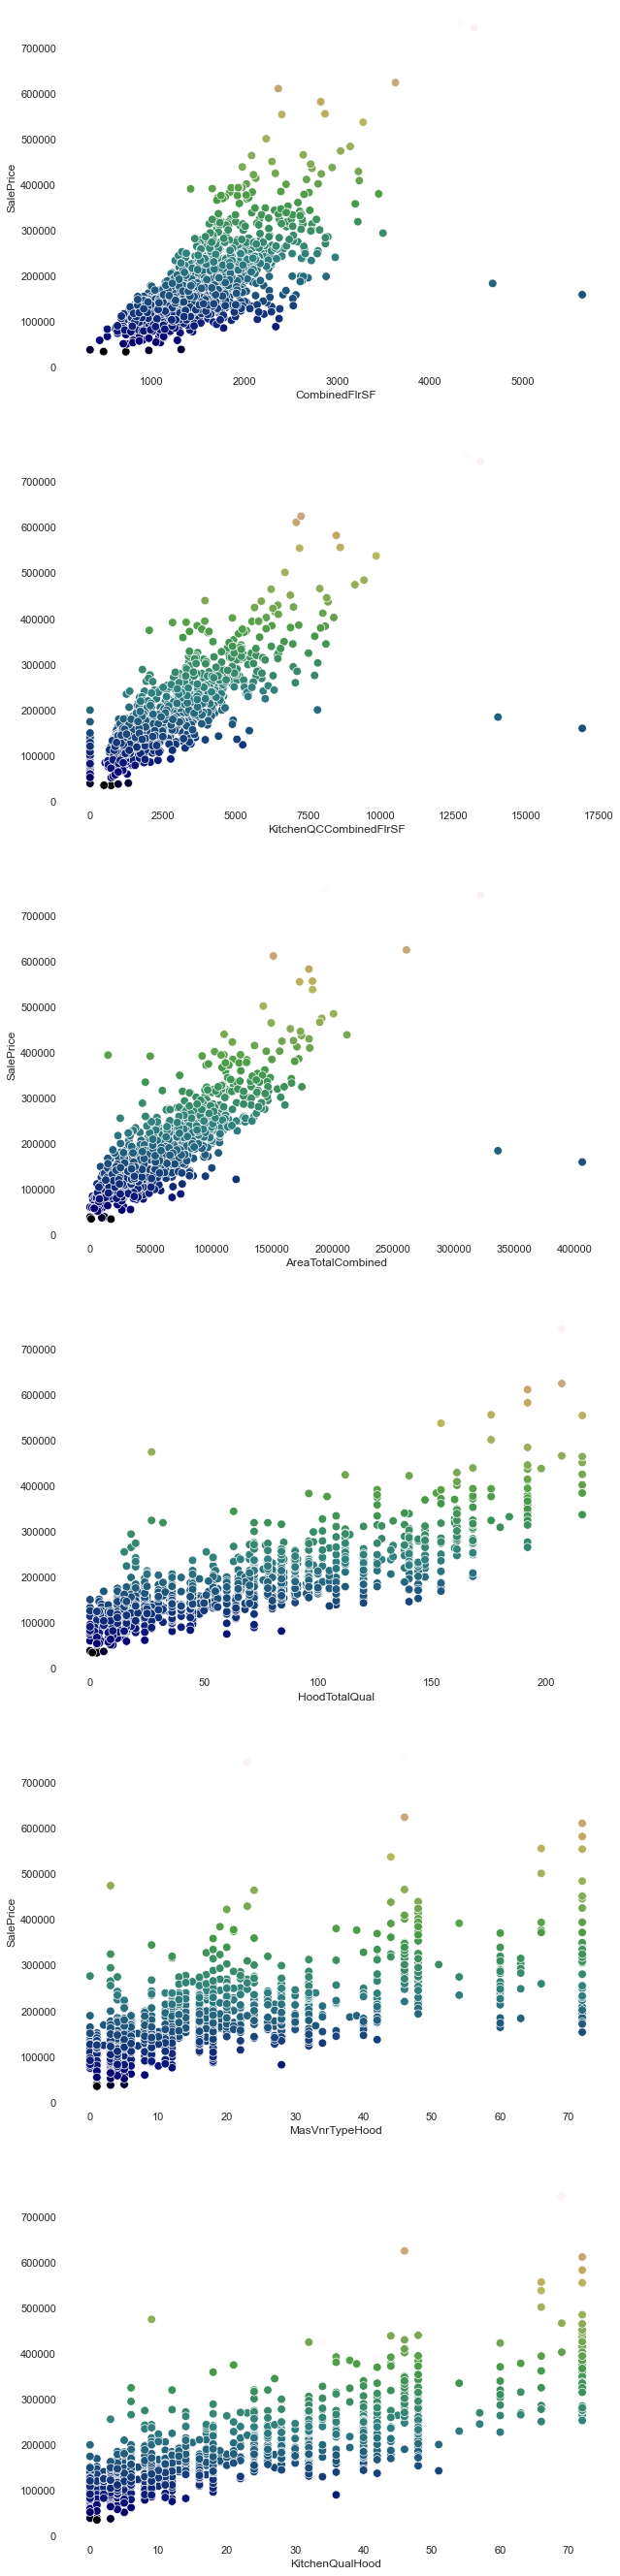

In [22]:
# Visualizing correlation between new features and the target variable.
cols_to_viz = ["CombinedFlrSF", "KitchenQCCombinedFlrSF", "AreaTotalCombined", "HoodTotalQual", "MasVnrTypeHood", "KitchenQualHood"]

ncols = 1
nrows = math.ceil(len(cols_to_viz) / ncols)
unused = (nrows * ncols) - len(cols_to_viz)

figw, figh = ncols*10, nrows*8

fig, ax = plt.subplots(nrows, ncols, sharey=True, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = ax.flatten()
for i in range(unused, 0, -1):
    fig.delaxes(ax[-i])


for n, col in enumerate(cols_to_viz):
    if n % 2 != 0: ax[n].yaxis.label.set_visible(False)
    ax[n].set_xlabel(col)
    ax[n].set_ylabel("SalePrice")
    sns.scatterplot(x=col, y="SalePrice", data=combined_DF.loc[combined_DF["Train"] == 1], hue="SalePrice", palette='gist_earth', s=75, legend=False, ax=ax[n])
plt.show()

**Dealing with highly skewed variables**

In [23]:
combined_DF[combined_DF["Train"] == 1].skew()[abs(combined_DF[combined_DF["Train"] == 1].skew()) > 5]

LotArea        12.21
LowQualFinSF    9.01
3SsnPorch      10.30
PoolArea       14.83
MiscVal        24.48
HeatingRank    -9.59
PorchHood      10.55
dtype: float64

In [24]:
# Now we'll apply yeo-johnson transformation on highly skewed variables.

highly_skewed_cols = combined_DF[combined_DF["Train"] == 1].skew()[abs(combined_DF[combined_DF["Train"] == 1].skew()) > 5].index.to_list()

ptransformer = PowerTransformer(standardize=False)
combined_DF.loc[combined_DF["Train"] == 1, highly_skewed_cols] = ptransformer.fit_transform(combined_DF.loc[combined_DF["Train"] == 1, highly_skewed_cols])
combined_DF.loc[combined_DF["Train"] == 0, highly_skewed_cols] = ptransformer.transform(combined_DF.loc[combined_DF["Train"] == 0, highly_skewed_cols])


 - We'll apply one hot encoding to categorical variables, and scaling on numerical variables (except boolean-like features). 
 - We'll then pass transformed variables through Variance Threshold to remove any feature with less variance.

Note: We apply seperate OneHot encoding to two different subset of categorical variables - test and train sets as few features have different set of categories.

In [25]:
# Obtaining a list of categorical, numerical, and boolean - like features.
bool_features = [col for col in combined_DF.select_dtypes(include=["number"]).columns if np.array_equal(np.sort(combined_DF[col].unique(), axis=0), np.sort([0, 1], axis=0))]
cat_features = [col for col in combined_DF.select_dtypes(exclude=["number"]).columns]
num_features = [col for col in combined_DF.select_dtypes(include=["number"]).columns if col not in (bool_features) and col != "SalePrice"]

# Keeping these two DFs to concatenate later with the preprocessed(scaled and onehot encoded) DF.
bool_features.remove("Train")
X_train_bool = combined_DF.loc[combined_DF["Train"] == 1, bool_features]
X_test_bool = combined_DF.loc[combined_DF["Train"] == 0, bool_features]

# This list contains features that has the same set of values between train - test
ohe_cols_a = []

# This list contains features that has different set of values between train - test
ohe_cols_b = []

for col in cat_features:
    if set(combined_DF.loc[combined_DF["Train"] == 1, col].unique()) != set(combined_DF.loc[combined_DF["Train"] == 0, col].unique()): ohe_cols_b.append(col)

ohe_cols_a = list(set(cat_features) - set(ohe_cols_b))

In [26]:
X_train = combined_DF.loc[combined_DF["Train"] == 1].drop(labels=["SalePrice", "Train"], axis=1)

# Applying log transformation to the target variable
y_train = combined_DF.loc[combined_DF["Train"] == 1, "SalePrice"].apply(np.log)
X_test = combined_DF.loc[combined_DF["Train"] == 0].drop(labels=["SalePrice", "Train"], axis=1)

preprocessor = ColumnTransformer(transformers=[("onehota", OneHotEncoder(sparse=False, drop="first"), ohe_cols_a), ("onehotb", OneHotEncoder(sparse=False, handle_unknown="ignore"), ohe_cols_b), 
                                               ("scaler", StandardScaler(), num_features)],remainder="drop")


pipeline = Pipeline([("Preprocessor", preprocessor), ("VarThreshold", VarianceThreshold(0.01))])
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Get the list of one hot encoded columns and combine them
oh_encoded_a = list(preprocessor.named_transformers_.onehota.get_feature_names(ohe_cols_a))
oh_encoded_b = list(preprocessor.named_transformers_.onehotb.get_feature_names(ohe_cols_b))
oh_encoded_cols = oh_encoded_a + oh_encoded_b
feature_names = np.array(oh_encoded_cols + num_features, order="K")

# Filtering out the features dropped by variance threshold
feature_names = feature_names[pipeline.named_steps.VarThreshold.get_support()]

# Putting back the column names to help with analysis
X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed, columns=feature_names, index=X_test_bool.index)

# Combine the DF's back together
X_train = pd.concat([X_train_bool, X_train_preprocessed], axis=1)
X_test = pd.concat([X_test_bool, X_test_preprocessed], axis=1)


# Feature Importance

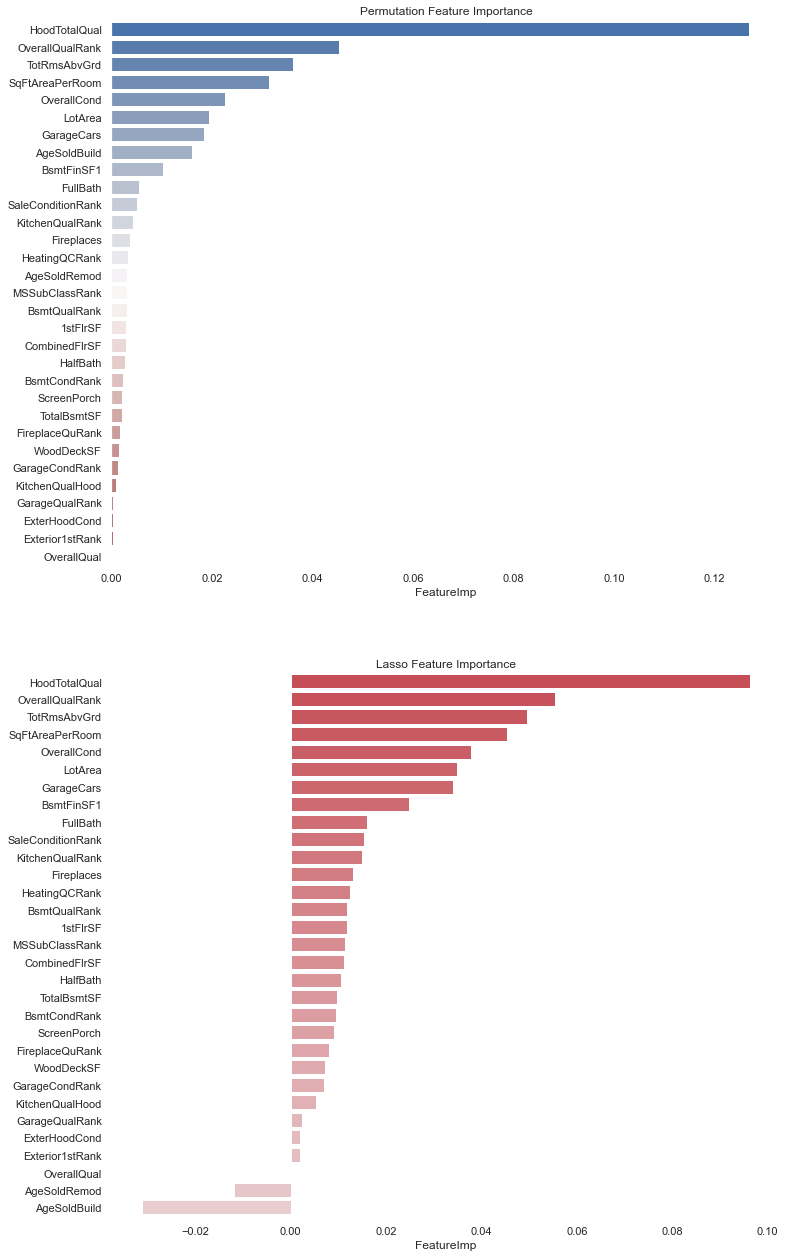

In [27]:
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)

# Note: one pitfall of permutation importance is that it doesn't do the best job when it comes to correlated independent variables
feature_imp = permutation_importance(model, X_train, y_train, n_repeats=10, n_jobs=-1, random_state=random_state)

perm_ft_imp_df = pd.DataFrame(data=feature_imp.importances_mean, columns=["FeatureImp"], index=X_train.columns).sort_values(by="FeatureImp", ascending=False)
model_ft_imp_df = pd.DataFrame(data=model.coef_, columns=["FeatureImp"], index=X_train.columns).sort_values(by="FeatureImp", ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(12, 22))

perm_ft_imp_df_nonzero = perm_ft_imp_df[perm_ft_imp_df["FeatureImp"] != 0]
model_ft_imp_df_nonzero = model_ft_imp_df[model_ft_imp_df["FeatureImp"] != 0]

sns.barplot(x=perm_ft_imp_df_nonzero["FeatureImp"], y=perm_ft_imp_df_nonzero.index, ax=ax[0], palette="vlag")
sns.barplot(x=model_ft_imp_df_nonzero["FeatureImp"], y=model_ft_imp_df_nonzero.index, ax=ax[1], palette=sns.diverging_palette(10, 220, sep=2, n=80))
ax[0].set_title("Permutation Feature Importance")
ax[1].set_title("Lasso Feature Importance")
plt.show()

- Features like OverallQual, Neighborhood, GrLivArea and Year built rank high in our models.
- Some of the hand engineered features rank high in both lists.

In [28]:
rf_params = {"max_depth": 8, "max_features": 40, "n_estimators": 132}
svr_params = {"kernel": "poly","C": 0.053677105521141605,"epsilon": 0.03925943476562099, "coef0": 0.9486751042886584}
ridge_params = {"alpha": 0.9999189637151178, "tol": 0.8668539399622242, "solver": "cholesky"}
lasso_params = {"alpha": 0.0004342843645993161, "selection": "random"}

# Model Performance Comparison

We'll use cross-validate-score to compare model performance.

In [29]:
cv = KFold(n_splits=4, random_state=random_state)

svr = SVR(**svr_params)
ridge = Ridge(**ridge_params, random_state=random_state)
lasso = Lasso(**lasso_params, random_state=random_state)
rf = RandomForestRegressor(**rf_params, random_state=random_state)
stack = StackingCVRegressor(regressors=[svr, ridge, lasso, rf], meta_regressor=LinearRegression(n_jobs=-1), random_state=random_state, cv=cv, n_jobs=-1)

svr_scores = cross_val_score(svr, X_train, y_train, cv=cv, n_jobs=-1)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=cv, n_jobs=-1)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=cv, n_jobs=-1)
rf_scores = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
stack_scores = cross_val_score(stack, X_train, y_train, cv=cv, n_jobs=-1)

In [30]:
scores = [svr_scores, ridge_scores, lasso_scores, rf_scores, stack_scores]
models = ["SVR", "RIDGE", "LASSO", "RF", "STACK"]
score_medians = [round(np.median([mean for mean in modelscore]), 5) for modelscore in scores]

fig, ax = plt.subplots(figsize=(14, 8))
vertical_offset = 0.001

ax.set_title("Model Performance Comparison")
bp = sns.boxplot(x=models, y=scores, ax=ax)

for xtick in bp.get_xticks():
    bp.text(xtick, score_medians[xtick] - vertical_offset, score_medians[xtick], horizontalalignment="center", size=18, color="w", weight="semibold")
plt.show()

# Submission

Below we submit the inverse log-transformed results.<br><br>

In [31]:
lasso.fit(X_train.values, y_train.values)
stack.fit(X_train.values, y_train.values)
svr.fit(X_train.values, y_train.values)

SVR(C=0.053677105521141605, coef0=0.9486751042886584,
    epsilon=0.03925943476562099, kernel='poly')

In [32]:
def blend_models_predict(X_test):
    return ((0.4 * stack.predict(X_test.values)) + \
            (0.25 * lasso.predict(X_test.values)) + \
            (0.35 * svr.predict(X_test.values)))

In [33]:
predictions = blend_models_predict(X_test)
predictions = np.exp(predictions)

submission = pd.DataFrame({"Id": submission_ID, "SalePrice": predictions})
submission.to_csv("submission.csv", index=False)